In [1]:
import json
import pprint
from pathlib import Path
import sys
sys.path.insert(1, '../src/utils')
import ipdb
import itertools
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import Word2Vec
from gensim.models import CoherenceModel
from sklearn.manifold import TSNE
from sklearn.cluster import OPTICS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from scipy.spatial.distance import cdist

from data import preprocessing

import pickle

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\Donat\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Donat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Variables


In [4]:
num_topics = 5
use_title = True
# don't use stemming
stemming = False
lemmatization = True
# use nltk since it is a lot faster than spacy and the results are better with nltk
lib = "nltk"

input_path = Path("../src/data/data_jmlr_vol13-21.json")

# Data loading and preparation

## Load data

In [37]:
def load_data():
    with open(input_path, encoding="utf-8") as f:
        data = json.load(f)
    data_df = pd.json_normalize(data['papers'])
    corpus = data_df["abstract"]
    if use_title:
        corpus = data_df["title"] + " " + corpus 
    return corpus

corpus = load_data()


## Preprocessing

In [6]:
corpus = preprocessing(
    corpus,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Donat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Donat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
0it [00:00, ?it/s]

Dropping 0 entries of corpus, due to nan ...
Starting tokenization ...


1261it [00:06, 206.21it/s]


### TD-IDF

The TfidfVectorizer does additionally also tokenization and stop word removal. Use two different methods of vectorizing

In [7]:
vectorizer_sklearn = TfidfVectorizer(stop_words='english')
tfidf_corpus_sklearn_preprocessed = vectorizer_sklearn.fit_transform(corpus["abstract"])

In [8]:
vectorizer = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus =  vectorizer.fit_transform(corpus["token"])

# Clustering

In [9]:
def fit_model(model, corpus):
    model.fit(corpus)

In [29]:
tdidf_optics_clustering = pickle.load(open('optics_data/optics_tdidf_optics_clustering', 'rb'))

In [30]:
tdidf_optics_clustering_sklearn_prepocessed = pickle.load(open('optics_data/optics_tdidf_optics_clustering_sklearn_prepocessed', 'rb'))

In [31]:
def print_cluster_terms_count(model, corpus, vectorizer):
    print('Number of clusters:', len(model.cluster_hierarchy_))

print_cluster_terms_count(tdidf_optics_clustering, tfidf_corpus, vectorizer)
print_cluster_terms_count(tdidf_optics_clustering_sklearn_prepocessed, tfidf_corpus_sklearn_preprocessed, vectorizer_sklearn)

Number of clusters: 3
Number of clusters: 2


In [32]:
def get_top_words(vectorizer, corpus):
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(corpus.sum(axis=0)).ravel())
    sorted_scores = list(zip(*sorted(scores, key=lambda x: x[1], reverse=True)))
    top_words = sorted_scores[0][:10]
    return top_words
    

def print_and_get_clusters(model, corpus):
    labels = model.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    if (n_clusters_ == 0):
        print('No clusters found')
        return
    
    clusters = []
    print("Top terms per cluster:")
    for i in range(n_clusters_):
        print("Cluster %d:" % i)
        vectorizer_terms = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
        tfidf_corpus_terms = vectorizer_terms.fit_transform(corpus.iloc[np.where(model.labels_ == i)]["token"])
        top_words = get_top_words(vectorizer_terms, tfidf_corpus_terms)
        print(top_words)
        clusters.append(top_words)
        print("\n")
        
    return clusters

clusters = print_and_get_clusters(tdidf_optics_clustering, corpus)
#print_and_get_clusters(tdidf_optics_clustering_sklearn_prepocessed, tfidf_corpus_sklearn_preprocessed, vectorizer_sklearn)

Top terms per cluster:
Cluster 0:
('change', 'point', 'model', 'graphical', 'algorithm', 'surface', 'regression', 'data', 'selection', 'number')


Cluster 1:
('persistence', 'data', 'topological', 'landscape', 'summary', 'diagram', 'statistical', 'kernel', 'method', 'multiparameter')




# Visualization

In [23]:
def visualize_clustering_result(model, corpus):
    space = np.arange(len(corpus.toarray()))
    reachability = model.reachability_[model.ordering_]
    labels = model.labels_[model.ordering_]
    
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    
    # Reachability plot
    colors = ['g.', 'r.', 'b.', 'y.', 'c.']
    for klass, color in zip(range(0, 5), colors):
        Xk = space[labels == klass]
        Rk = reachability[labels == klass]
        ax1.plot(Xk, Rk, color, alpha=0.3)
    ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
    ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
    ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
    ax1.set_ylabel('Reachability (epsilon distance)')
    ax1.set_title('Reachability Plot')

    # OPTICS
    colors = ['g.', 'r.', 'b.', 'y.', 'c.']
    for klass, color in zip(range(0, 5), colors):
        Xk = corpus.toarray()[model.labels_ == klass]
        ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
    ax2.plot(corpus.toarray()[model.labels_ == -1, 0], corpus.toarray()[model.labels_ == -1, 1], 'k+', alpha=0.1)
    ax2.set_title('Automatic Clustering\nOPTICS')
    
    plt.show()

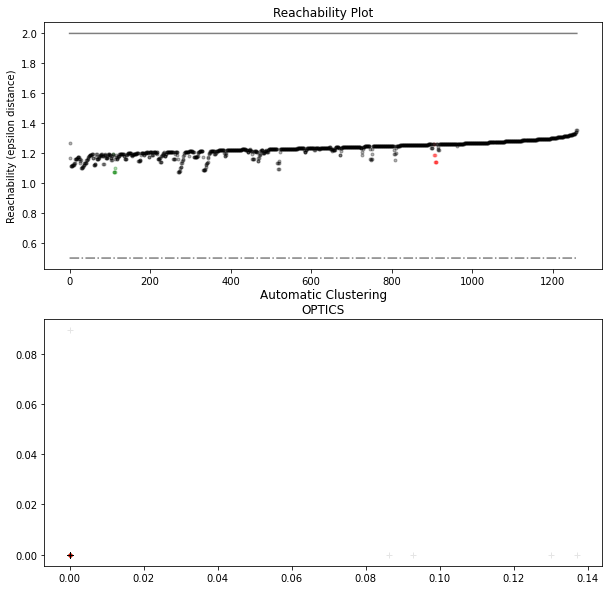

In [24]:
visualize_clustering_result(tdidf_optics_clustering, tfidf_corpus)

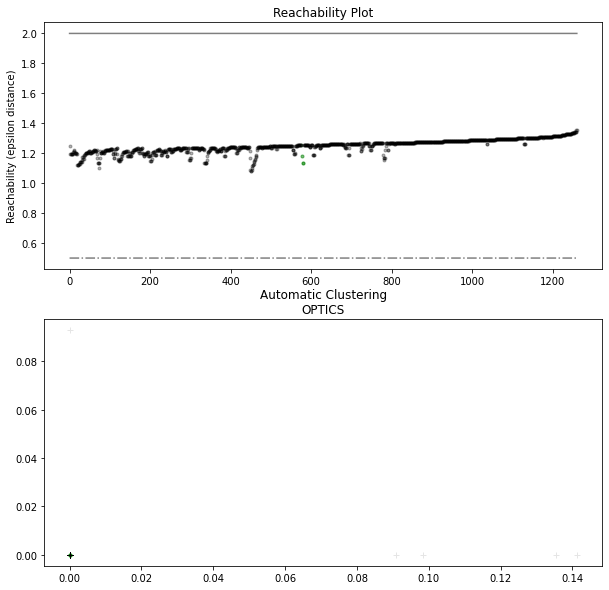

In [25]:
visualize_clustering_result(tdidf_optics_clustering_sklearn_prepocessed, tfidf_corpus_sklearn_preprocessed)

# Try different arguments for `OPTICS`

Without sklearn:
min_samples: 5, max_eps: 5


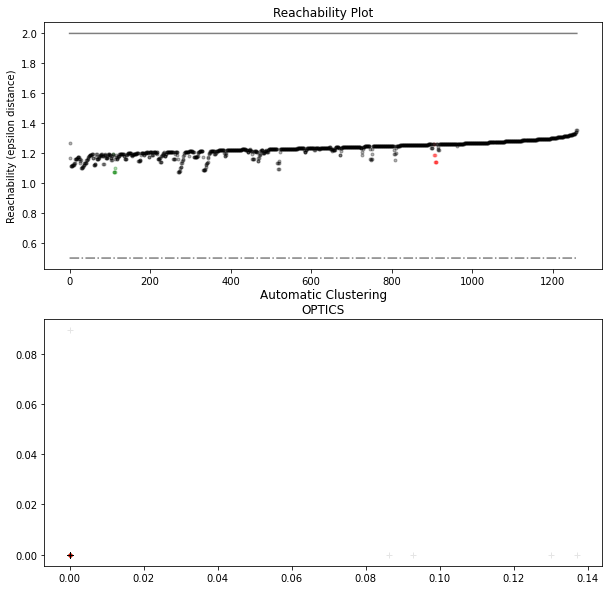

min_samples: 5, max_eps: inf


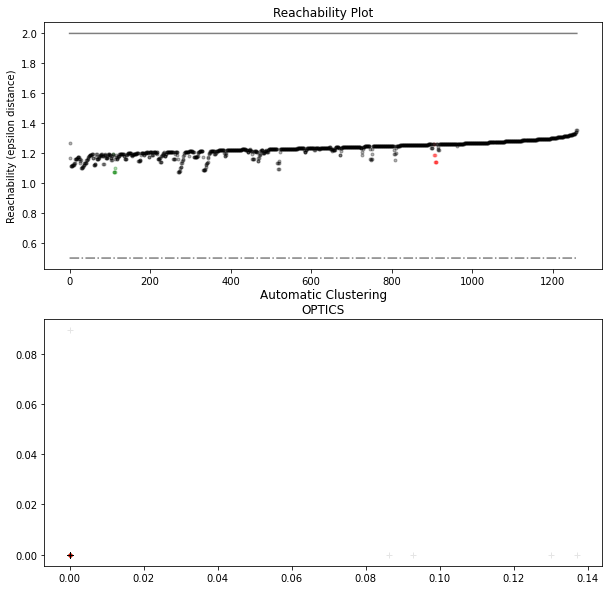

min_samples: 10, max_eps: 5


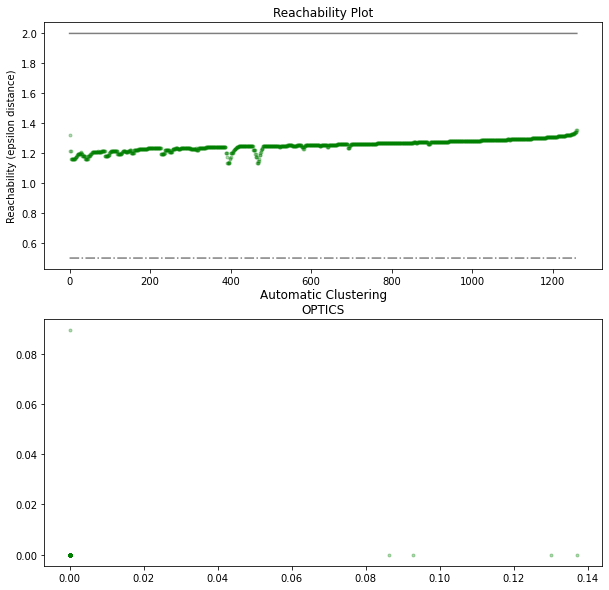

min_samples: 10, max_eps: inf


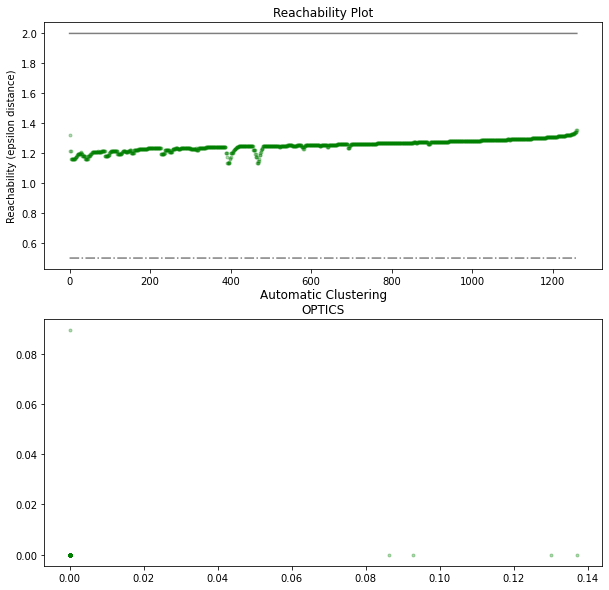

min_samples: 20, max_eps: 5


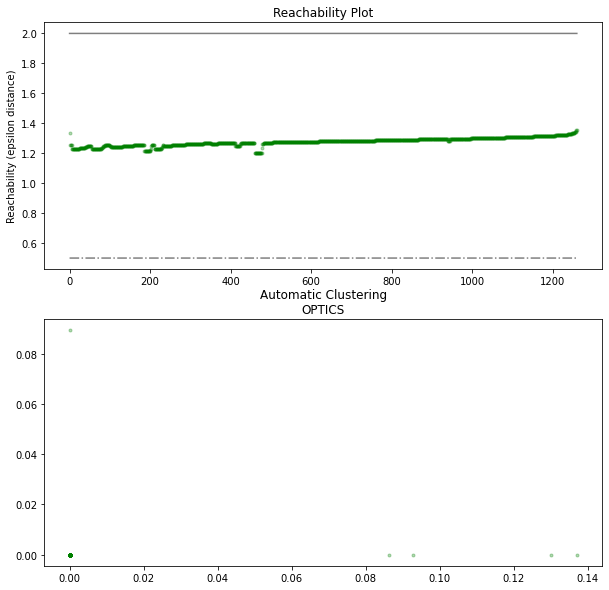

min_samples: 20, max_eps: inf


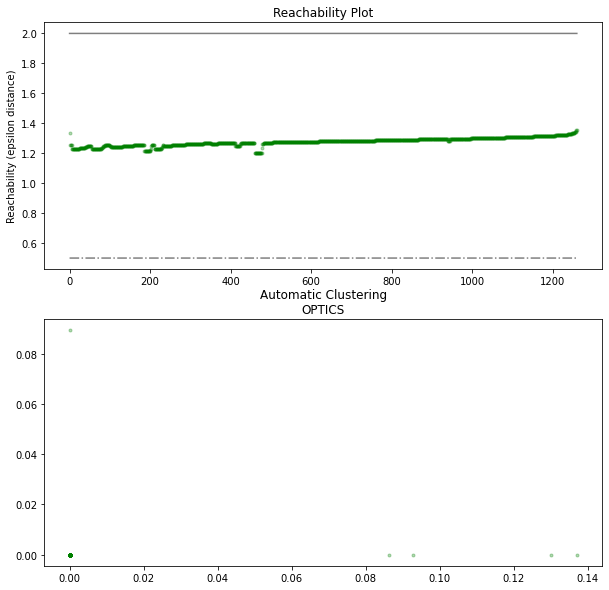

In [33]:
min_samples = [5, 10, 20]
max_eps = [5, np.inf]

argument_perm_models = []

print('Without sklearn:')
for samples in min_samples:
    for eps in max_eps:
        print(f'min_samples: {samples}, max_eps: {eps}')
        
        tdidf_optics_clustering_args = pickle.load(open(f'optics_data/optics_wo-sklearn_{samples}_{eps}', 'rb'))
        visualize_clustering_result(tdidf_optics_clustering_args, tfidf_corpus)
        
        argument_perm_models += [(samples, eps, tdidf_optics_clustering_args)]
        
#print('\nWith sklearn:')
#for samples in min_samples:
#    for eps in max_eps:
#        print(f'min_samples: {samples}, max_eps: {eps}')
#        
#        tdidf_optics_clustering_sklearn_prepocessed = pickle.load(open(f'optics_data/optics_w-sklearn_{samples}_{eps}', 'rb'))
#        visualize_clustering_result(tdidf_optics_clustering_sklearn_prepocessed, tfidf_corpus_sklearn_preprocessed)

#  Remove words which appear often in all clusters

In [34]:
terms = list(itertools.chain.from_iterable(clusters))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'data': 2, 'change': 1, 'point': 1, 'model': 1, 'graphical': 1, 'algorithm': 1, 'surface': 1, 'regression': 1, 'selection': 1, 'number': 1, 'persistence': 1, 'topological': 1, 'landscape': 1, 'summary': 1, 'diagram': 1, 'statistical': 1, 'kernel': 1, 'method': 1, 'multiparameter': 1})>

In [35]:
custom_stopwords = ["data"]

In [38]:
corpus_stopwords = load_data()

corpus_stopwords = preprocessing(
    corpus_stopwords,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15,
    custom_stopwords = custom_stopwords
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Donat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Donat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
52it [00:00, 509.81it/s]

Dropping 0 entries of corpus, due to nan ...
Starting tokenization ...


1261it [00:02, 433.48it/s]


In [39]:
vectorizer_stopwords = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus_stopwords = vectorizer_stopwords.fit_transform(corpus_stopwords["token"])

In [40]:
tdidf_optics_clustering_stopwords = OPTICS(n_jobs=6)
tdidf_optics_clustering_stopwords = tdidf_optics_clustering_stopwords.fit(tfidf_corpus_stopwords.toarray())

In [41]:
print_cluster_terms_count(tdidf_optics_clustering_stopwords, tfidf_corpus_stopwords, vectorizer_stopwords)

Number of clusters: 5


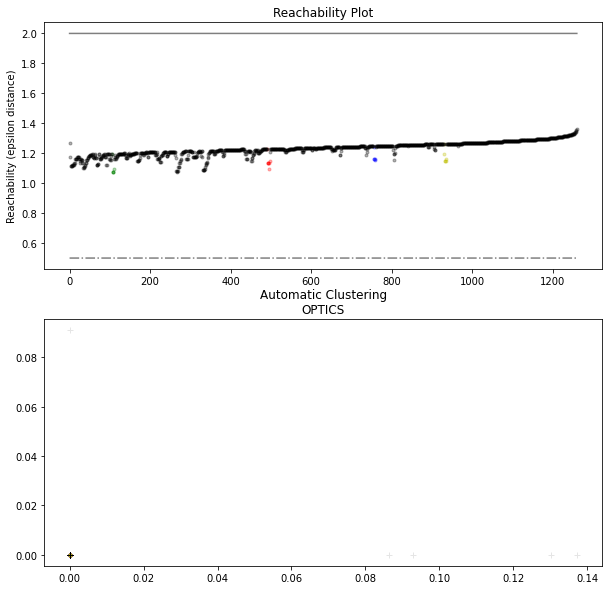

In [42]:
visualize_clustering_result(tdidf_optics_clustering_stopwords, tfidf_corpus_stopwords)

In [43]:
clusters_stopwords = print_and_get_clusters(tdidf_optics_clustering_stopwords, corpus_stopwords)

Top terms per cluster:
Cluster 0:
('change', 'point', 'model', 'graphical', 'algorithm', 'surface', 'regression', 'selection', 'number', 'kernel')


Cluster 1:
('subspace', 'method', 'problem', 'recovery', 'sparse', 'robust', 'dimension', 'underlying', 'learning', 'convex')


Cluster 2:
('privacy', 'learning', 'concept', 'private', 'sample', 'utility', 'complexity', 'differential', 'mechanism', 'method')


Cluster 3:
('persistence', 'topological', 'landscape', 'summary', 'diagram', 'kernel', 'statistical', 'method', 'multiparameter', 'analysis')




# Metrics 

In [44]:
def calc_scores(corpus, model):
    return metrics.silhouette_score(corpus, model.labels_, metric='euclidean'), metrics.calinski_harabasz_score(corpus.toarray(), model.labels_), metrics.davies_bouldin_score(corpus.toarray(), model.labels_)

scores = []

score = list(calc_scores(tfidf_corpus, tdidf_optics_clustering))
score.insert(0, 'normal model')
scores.append(score)

score = list(calc_scores(tfidf_corpus_sklearn_preprocessed, tdidf_optics_clustering_sklearn_prepocessed))
score.insert(0, 'normal model (sklearn)')
scores.append(score)

score = list(calc_scores(tfidf_corpus_stopwords, tdidf_optics_clustering_stopwords))
score.insert(0, 'model with custom stopwords')
scores.append(score)

for samples, eps, arg_perm_model in argument_perm_models:
    try:
        score = list(calc_scores(tfidf_corpus, arg_perm_model))
        score.insert(0, f'normal model with min_samples: {samples}, eps: {eps}')
        scores.append(score)
    except:
        pass

scores = pd.DataFrame(scores, columns=["model type","silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"])
print(scores)

                                   model type  silhouette_score  \
0                                normal model         -0.003231   
1                      normal model (sklearn)          0.004514   
2                 model with custom stopwords         -0.004380   
3    normal model with min_samples: 5, eps: 5         -0.003231   
4  normal model with min_samples: 5, eps: inf         -0.003231   

   calinski_harabasz_score  davies_bouldin_score  
0                 2.455650              2.620644  
1                 2.544701              2.706585  
2                 2.567746              2.628210  
3                 2.455650              2.620644  
4                 2.455650              2.620644  
